# Ví dụ 1

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
solvers.options['show_progress'] = False

In [76]:
np.random.seed(0)
n_per_class = 100
means = np.array([[0.0, 0.0],[3.0, 3.0],[0.0, 4.0]])
cov = np.array([[0.4, 0.0],[0.0, 0.4]])

X_list, y_list = [], []
for k, mu in enumerate(means):
    Xk = np.random.multivariate_normal(mu, cov, n_per_class)
    yk = np.full(n_per_class, k, dtype=int)
    X_list.append(Xk); y_list.append(yk)

X = np.vstack(X_list); y = np.concatenate(y_list)
n, d0 = X.shape; K = len(np.unique(y))
print("X:", X.shape, "y:", y.shape, "K:", K)

X: (300, 2) y: (300,) K: 3


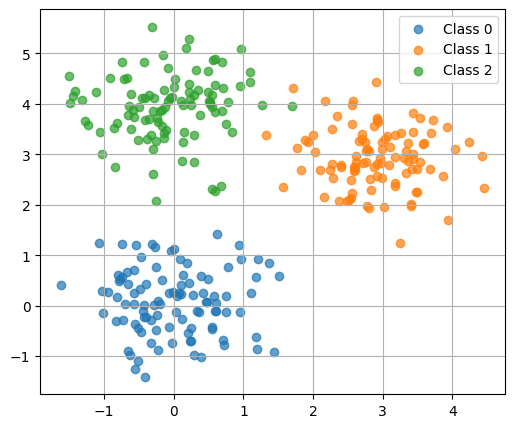

In [77]:
plt.figure(figsize=(6,5))
for k in range(K):
    plt.scatter(X[y==k,0], X[y==k,1], label=f"Class {k}", alpha=0.7)
plt.legend(); plt.grid(True); plt.show()

In [78]:
USE_BIAS = True
if USE_BIAS:
    Xb = np.hstack([X, np.ones((n,1))])
else:
    Xb = X.copy()
n, d = Xb.shape
print("Using bias:", USE_BIAS, "| d =", d)

Using bias: True | d = 3


In [79]:
C = 1.0
pairs = [(i,k) for i in range(n) for k in range(K) if k != y[i]]
m = len(pairs)
print("m =", m, "expected =", n*(K-1))

m = 600 expected = 600


In [80]:
# Gram matrix
Gx = Xb @ Xb.T

P = np.zeros((m,m), float)
for p,(i,k) in enumerate(pairs):
    yi = y[i]
    for q,(j,l) in enumerate(pairs):
        yj = y[j]
        val = 0.0
        if yi == yj: val += 1.0
        if yi == l:  val -= 1.0
        if yj == k:  val -= 1.0
        if k == l:   val += 1.0
        P[p,q] = val * Gx[i,j]

q = -np.ones(m)
# Inequalities:
# (1) alpha >= 0  -> -I a <= 0
G1 = -np.eye(m); h1 = np.zeros(m)
# (2) sum_k alpha_{i,k} <= C
Aineq = np.zeros((n,m))
for t,(i,k) in enumerate(pairs):
    Aineq[i,t] = 1.0
G = np.vstack([G1, Aineq])
h = np.concatenate([h1, C*np.ones(n)])

In [81]:
sol = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h))
alpha = np.array(sol['x']).reshape(-1)
print("status:", sol['status'], "| nnz(alpha>1e-8):", (alpha>1e-8).sum())

status: optimal | nnz(alpha>1e-8): 35


In [82]:
W = np.zeros((K,d))
for t,(i,k) in enumerate(pairs):
    a = alpha[t]
    if a>0:
        W[y[i]] += a*Xb[i]
        W[k]    -= a*Xb[i]
print("W:", W.shape)

W: (3, 3)


In [83]:
def predict(Xin):
    return np.argmax(Xin @ W.T, axis=1)

y_pred = predict(Xb)
print("Accuracy:", accuracy_score(y, y_pred))
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, digits=4))

Accuracy: 0.9933333333333333
[[100   0   0]
 [  0  99   1]
 [  0   1  99]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       100
           1     0.9900    0.9900    0.9900       100
           2     0.9900    0.9900    0.9900       100

    accuracy                         0.9933       300
   macro avg     0.9933    0.9933    0.9933       300
weighted avg     0.9933    0.9933    0.9933       300



In [84]:
eps=1e-5
sv_vars = np.where(alpha>eps)[0]
sv_pts = np.unique([pairs[t][0] for t in sv_vars])
print("Support vectors:", len(sv_pts))

Support vectors: 22


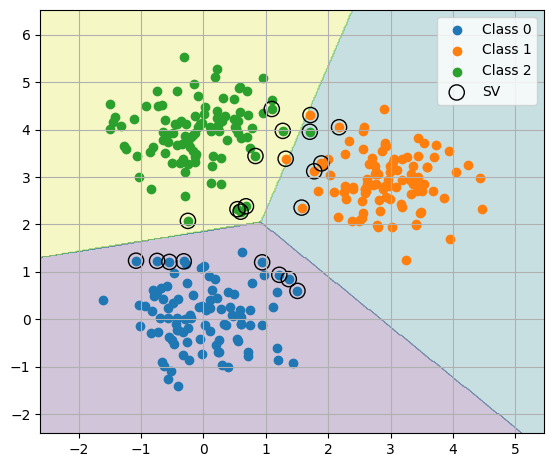

In [85]:
x1min,x1max = X[:,0].min()-1, X[:,0].max()+1
x2min,x2max = X[:,1].min()-1, X[:,1].max()+1
xx,yy = np.meshgrid(np.linspace(x1min,x1max,400), np.linspace(x2min,x2max,400))
grid = np.c_[xx.ravel(), yy.ravel()]
gridb = np.hstack([grid, np.ones((grid.shape[0],1))]) if USE_BIAS else grid
Z = predict(gridb).reshape(xx.shape)

plt.figure(figsize=(6.5,5.5))
plt.contourf(xx,yy,Z,alpha=0.25)
for k in range(K):
    plt.scatter(X[y==k,0],X[y==k,1],label=f"Class {k}")
plt.scatter(X[sv_pts,0],X[sv_pts,1],s=120,facecolors='none',edgecolors='k',label='SV')
plt.legend(); plt.grid(True); plt.show()

In [86]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=1.0)
clf.fit(X, y)
y_pred = clf.predict(X)
print(accuracy_score(y, y_pred))
print(confusion_matrix(y, y_pred))

0.9933333333333333
[[100   0   0]
 [  0  99   1]
 [  0   1  99]]


# Ví dụ 2

In [87]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [88]:
np.random.seed(0)
n_per_class=100
means=np.array([[0.,0.],[3.,3.],[0.,4.]])
cov=np.array([[0.4,0.],[0.,0.4]])
X_list,y_list=[],[]
for k,mu in enumerate(means):
    Xk=np.random.multivariate_normal(mu,cov,n_per_class)
    yk=np.full(n_per_class,k,int)
    X_list.append(Xk); y_list.append(yk)
X=np.vstack(X_list); y=np.concatenate(y_list)
n,d=X.shape; K=len(np.unique(y))

In [89]:
def train_multiclass_svm_hinge_sum(
    X, y, K,
    lr=0.5, lam=0.01, epochs=300,
    use_bias=True, shuffle=True, verbose=True
):
    n, d0 = X.shape
    Xb = np.hstack([X, np.ones((n,1))]) if use_bias else X
    n, d = Xb.shape

    W = 0.001 * np.random.randn(K, d)  # tránh symmetry/collapse khi init 0

    hist = {"loss": [], "acc": []}

    for ep in range(1, epochs + 1):
        idxs = np.random.permutation(n) if shuffle else np.arange(n)

        grad = lam * W
        hinge_sum = 0.0

        for i in idxs:
            xi = Xb[i]
            yi = y[i]
            scores = xi @ W.T

            margins = scores - scores[yi] + 1.0
            margins[yi] = 0.0

            viol = np.where(margins > 0)[0]  # all violating classes
            if viol.size > 0:
                hinge_sum += margins[viol].sum()
                grad[yi] -= viol.size * xi
                grad[viol] += xi  # broadcast add to each violating row

        grad /= n  # IMPORTANT: average

        W -= lr * grad

        pred = np.argmax(Xb @ W.T, axis=1)
        acc = (pred == y).mean()
        loss = 0.5 * lam * np.sum(W*W) + (hinge_sum / n)

        hist["loss"].append(loss)
        hist["acc"].append(acc)

        if verbose and (ep == 1 or ep % 20 == 0):
            print(f"Epoch {ep:4d}: loss={loss:.4f} acc={acc:.4f} hinge={hinge_sum/n:.4f}")

    return W, hist, Xb


Epoch    1: loss=2.0196 acc=0.7633 hinge=2.0024
Epoch   20: loss=0.0788 acc=0.9900 hinge=0.0540
Epoch   40: loss=0.0742 acc=0.9900 hinge=0.0418
Epoch   60: loss=0.0749 acc=0.9933 hinge=0.0376
Epoch   80: loss=0.0763 acc=0.9933 hinge=0.0338
Epoch  100: loss=0.0780 acc=0.9933 hinge=0.0302
Epoch  120: loss=0.0808 acc=0.9933 hinge=0.0277
Epoch  140: loss=0.0825 acc=0.9933 hinge=0.0250
Epoch  160: loss=0.0851 acc=0.9933 hinge=0.0230
Epoch  180: loss=0.0879 acc=0.9900 hinge=0.0211
Epoch  200: loss=0.0908 acc=0.9933 hinge=0.0193
Epoch  220: loss=0.0938 acc=0.9900 hinge=0.0179
Epoch  240: loss=0.0965 acc=0.9900 hinge=0.0169
Epoch  260: loss=0.0990 acc=0.9900 hinge=0.0163
Epoch  280: loss=0.1014 acc=0.9900 hinge=0.0157
Epoch  300: loss=0.1038 acc=0.9900 hinge=0.0152
Acc: 0.99
[[100   0   0]
 [  0  98   2]
 [  0   1  99]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       100
           1     0.9899    0.9800    0.9849       100
           2 

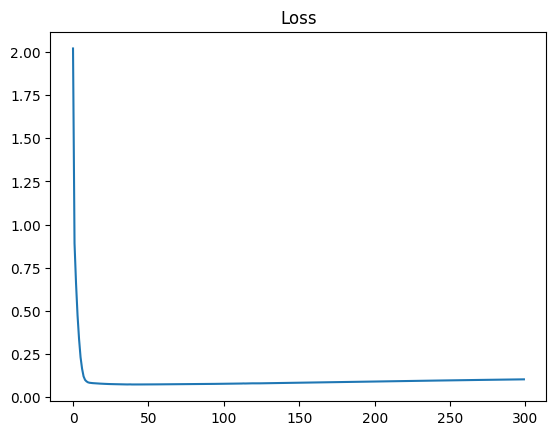

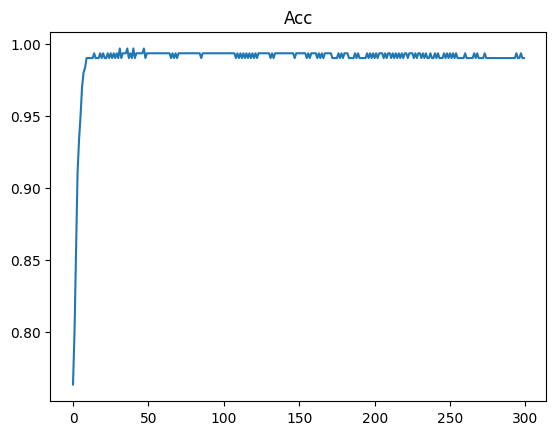

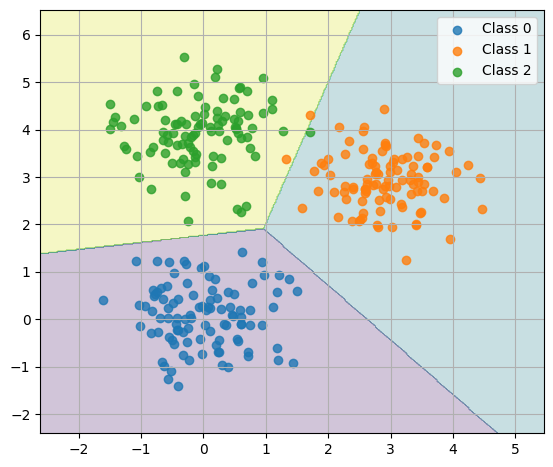

In [90]:
W, hist, Xb = train_multiclass_svm_hinge_sum(X, y, K)

y_pred = np.argmax(Xb @ W.T, axis=1)
print("Acc:", accuracy_score(y, y_pred))
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, digits=4))


plt.figure(); plt.plot(hist['loss']); plt.title("Loss"); plt.show()
plt.figure(); plt.plot(hist['acc']); plt.title("Acc"); plt.show()

grid = np.c_[xx.ravel(), yy.ravel()]                 # (N,2)
gridb = np.hstack([grid, np.ones((grid.shape[0],1))]) # (N,3)  <-- thêm bias
Z = np.argmax(gridb @ W.T, axis=1).reshape(xx.shape)


plt.figure(figsize=(6.5,5.5))
plt.contourf(xx, yy, Z, alpha=0.25)

for k in range(K):
    plt.scatter(X[y==k,0], X[y==k,1], label=f"Class {k}", alpha=0.8)

plt.legend()
plt.grid(True)
plt.show()



In [91]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=1.0)
clf.fit(X, y)
y_pred = clf.predict(X)
print(accuracy_score(y, y_pred))
print(confusion_matrix(y, y_pred))

0.9933333333333333
[[100   0   0]
 [  0  99   1]
 [  0   1  99]]


# Ví dụ 4

In [92]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X, y = load_iris(return_X_y=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)


In [94]:
clf = SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_pred=y_pred, y_true=y_test))
print(confusion_matrix(y_pred=y_pred, y_true=y_test))

0.9777777777777777
[[19  0  0]
 [ 0 12  1]
 [ 0  0 13]]


# Ví dụ 5

In [95]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

In [96]:
X, y = load_wine(return_X_y=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [97]:
C_values = [0.01, 0.1, 1, 10, 100]
print("OvR SVM (SVC kernel='linear')")
for C in C_values:
    svm_ovr = SVC(kernel='linear', C=C, decision_function_shape='ovr')
    svm_ovr.fit(X_train, y_train)

    y_pred = svm_ovr.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"C = {C:<6} | Accuracy = {acc:.4f}")
print("\nLinear SVM (LinearSVC)")
for C in C_values:
    svm_linear = LinearSVC(C=C, max_iter=10000)
    svm_linear.fit(X_train, y_train)

    y_pred = svm_linear.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"C = {C:<6} | Accuracy = {acc:.4f}")


OvR SVM (SVC kernel='linear')
C = 0.01   | Accuracy = 1.0000
C = 0.1    | Accuracy = 0.9815
C = 1      | Accuracy = 0.9815
C = 10     | Accuracy = 0.9815
C = 100    | Accuracy = 0.9815

Linear SVM (LinearSVC)
C = 0.01   | Accuracy = 0.9630
C = 0.1    | Accuracy = 0.9815
C = 1      | Accuracy = 0.9815
C = 10     | Accuracy = 0.9815
C = 100    | Accuracy = 0.9815


# Bài tập tự giải

In [98]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time
from sklearn.linear_model import SGDClassifier

In [99]:
X, y = load_digits(return_X_y=True)

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Dual SVM - Linear Kernel

In [100]:
start = time.time()
svc_linear = SVC(kernel="linear", C=1.0)
svc_linear.fit(X_train, y_train)
t_dual = time.time() - start

acc_dual = accuracy_score(y_test, svc_linear.predict(X_test))
print(f'Time: {t_dual}')
print(f'Accuracy: {acc_dual}')

Time: 0.04531097412109375
Accuracy: 0.9777777777777777


# Primal SVM - SGD(hinge loss)

In [101]:
start = time.time()
sgd = SGDClassifier(
    loss="hinge",
    learning_rate="optimal",
    max_iter=3000,
    tol=1e-3
)
sgd.fit(X_train, y_train)
t_primal = time.time() - start

acc_primal = accuracy_score(y_test, sgd.predict(X_test))
print(f'Time: {t_primal}')
print(f'Accuracy: {acc_primal}')

Time: 0.06300520896911621
Accuracy: 0.9518518518518518


## Mini-Batch SGD

In [102]:
import numpy as np

class MulticlassSVM:
    def __init__(self, lr=1e-3, reg=1e-4, epochs=50, batch_size=64):
        self.lr = lr
        self.reg = reg
        self.epochs = epochs
        self.batch_size = batch_size

    def fit(self, X, y):
        n, d = X.shape
        self.k = len(np.unique(y))
        self.W = np.zeros((self.k, d))

        for _ in range(self.epochs):
            idx = np.random.permutation(n)
            for i in range(0, n, self.batch_size):
                batch = idx[i:i+self.batch_size]
                self._update(X[batch], y[batch])

    def _update(self, Xb, yb):
        scores = Xb @ self.W.T
        correct = scores[np.arange(len(yb)), yb][:, None]
        margins = np.maximum(0, scores - correct + 1)
        margins[np.arange(len(yb)), yb] = 0

        grad = (margins > 0).astype(float)
        grad[np.arange(len(yb)), yb] = -np.sum(grad, axis=1)

        self.W -= self.lr * ((grad.T @ Xb) / len(yb) + self.reg * self.W)

    def predict(self, X):
        return np.argmax(X @ self.W.T, axis=1)


In [103]:
for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
    model = MulticlassSVM(lr=lr)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f'Learning rate: {lr} | Accuracy: {acc}')


Learning rate: 0.1 | Accuracy: 0.9629629629629629
Learning rate: 0.01 | Accuracy: 0.9648148148148148
Learning rate: 0.001 | Accuracy: 0.95
Learning rate: 0.0001 | Accuracy: 0.8814814814814815


## Kernel RBF

In [104]:
for g in [0.001, 0.01, 0.1, 1]:
    svc = SVC(kernel="rbf", gamma=g)
    svc.fit(X_train, y_train)
    acc = accuracy_score(y_test, svc.predict(X_test))
    print(f"Gamma ={g} | Accuracy = {acc}")


Gamma =0.001 | Accuracy = 0.9425925925925925
Gamma =0.01 | Accuracy = 0.975925925925926
Gamma =0.1 | Accuracy = 0.95
Gamma =1 | Accuracy = 0.1
